### Time series forecasting in TensorFlow
The goal of this notebook is to get you familiar with working with time series data and TensorFlow.
>⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

#### Get data
To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 08 Dec 2021.

Data source [Coindesk](https://www.coindesk.com/price/bitcoin/)

In [2]:
# Parse dates and set date column to index
df = pd.read_csv("data/BTC_USD_2013-10-01_2021-12-08-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2987 entries, 2013-10-01 to 2021-12-08
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2987 non-null   object 
 1   Closing Price (USD)  2987 non-null   float64
 2   24h Open (USD)       2987 non-null   float64
 3   24h High (USD)       2987 non-null   float64
 4   24h Low (USD)        2987 non-null   float64
dtypes: float64(4), object(1)
memory usage: 140.0+ KB


In [4]:
len(df)

2987

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.
Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


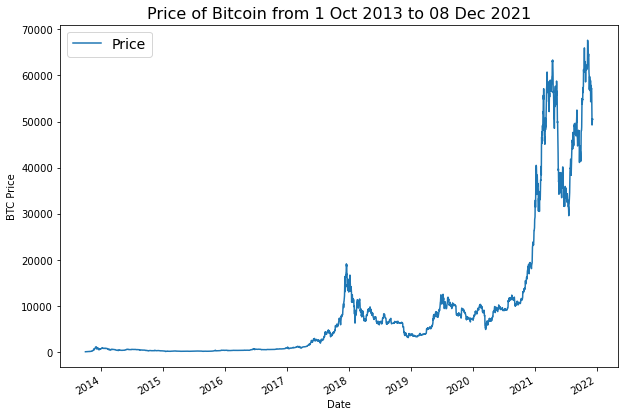

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 08 Dec 2021", fontsize=16)
plt.legend(fontsize=14);

#### Importing time series data with Python's CSV module
If your time series data comes in CSV form you don't necessarily have to use `pandas`.

You can use Python's in-built `csv` module.
And if you're working with dates, you might also want to use Python's `datetime`.

In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("data/BTC_USD_2013-10-01_2021-12-08-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates, not strings
        btc_price.append(float(line[2])) # get closing price as float

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

#### Create train & test sets for time series

In [8]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2389, 598, 2389, 598)

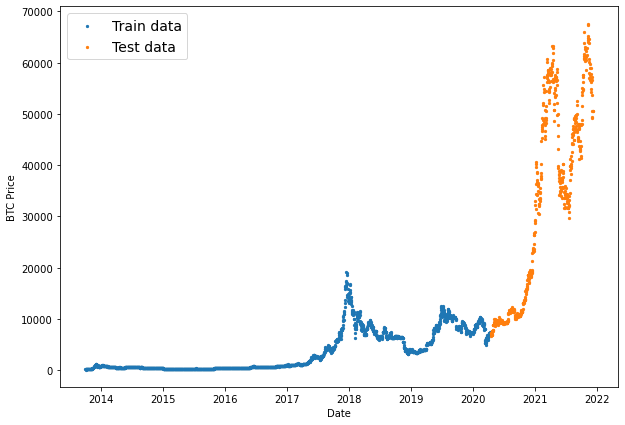

In [9]:
# Plot splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [10]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#### Experiment: Make a multivariate time series
Check if there is a positive correlation between halving and price.
- add another feature column, the block reward size.
- The following block rewards and dates were [sourced from cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving)

In [11]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [12]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [13]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


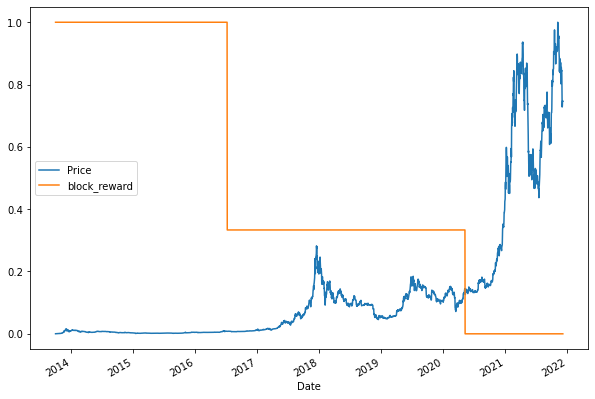

In [14]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

#### Train a model on the full historical data to make predictions into future
To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon.

In [15]:
# Making a windowed dataset with pandas
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [16]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [17]:
len(X_all), len(y_all)

(2980, 2980)

Windows and labels ready.
Let's turn them into performance optimized TensorFlow Datasets by:

- Turning `X_all` and `y_all` into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
- Combining the features and labels into a Dataset tuple using `tf.data.Dataset.zip()`
- Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively.

In [18]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [19]:
from tensorflow.keras import layers
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_full = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile the model
model_full.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
history = model_full.fit(dataset_all,
            epochs=100,
            verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 2ms/step - loss: 5935.5142
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 3223.6584
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 656.0505
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 2038.5154
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 2188.4561
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 1212.6595
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 559.5679
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 1010.3349
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 813.5450
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 465.6909
Epoch 11/100
3/3 [==============================] - 0s 2ms/step - loss: 677.9666
Epoch 12/100
3/3 [==============================] - 0s 2ms/step - loss: 554.1999
Epoch 13/100
3/3 [=============

#### Make predictions on the future
Let's predict the future =)
To do so, let's start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into the future.

In [20]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # our Bitcoin data is daily, this is for 14 days

In [21]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    
    # 2. Make an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
    for _ in range(into_future):
    
        # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
    return future_forecast

In [22]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_full,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56524.829562 53694.69     49266.12     49455.282036 50564.3
 50638.162863 50512.038512] -> Prediction: 54807.9140625

Predicting on: 
 [53694.69      49266.12      49455.282036  50564.3       50638.162863
 50512.038512  54807.9140625] -> Prediction: 51442.90234375

Predicting on: 
 [49266.12       49455.282036   50564.3        50638.162863
 50512.038512   54807.9140625  51442.90234375] -> Prediction: 49190.39453125

Predicting on: 
 [49455.282036   50564.3        50638.162863   50512.038512
 54807.9140625  51442.90234375 49190.39453125] -> Prediction: 50761.16015625

Predicting on: 
 [50564.3        50638.162863   50512.038512   54807.9140625
 51442.90234375 49190.39453125 50761.16015625] -> Prediction: 51781.76171875

Predicting on: 
 [50638.162863   50512.038512   54807.9140625  51442.90234375
 49190.39453125 50761.16015625 51781.76171875] -> Prediction: 50853.00390625

Predicting on: 
 [50512.038512   54807.9140625  51442.90234375 49190.39453125
 50761.16015625 517

In [23]:
future_forecast[:10]

[54807.914,
 51442.902,
 49190.395,
 50761.16,
 51781.76,
 50853.004,
 52339.355,
 53206.574,
 50487.945,
 50235.145]

In [24]:
def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
    end_date = start_date + np.timedelta64(into_future, "D") # specify end date
    return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [25]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-12-08 00:00:00')

In [26]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
       '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
       '2021-12-21', '2021-12-22'], dtype='datetime64[D]')

In [27]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-12-08', '2021-12-09', '2021-12-10', '2021-12-11',
        '2021-12-12', '2021-12-13', '2021-12-14', '2021-12-15',
        '2021-12-16', '2021-12-17', '2021-12-18', '2021-12-19',
        '2021-12-20', '2021-12-21', '2021-12-22'], dtype='datetime64[D]'),
 array([50512.04 , 54807.914, 51442.902, 49190.395, 50761.16 , 51781.76 ,
        50853.004, 52339.355, 53206.574, 50487.945, 50235.145, 52061.03 ,
        51925.402, 51506.77 , 52723.355], dtype=float32))

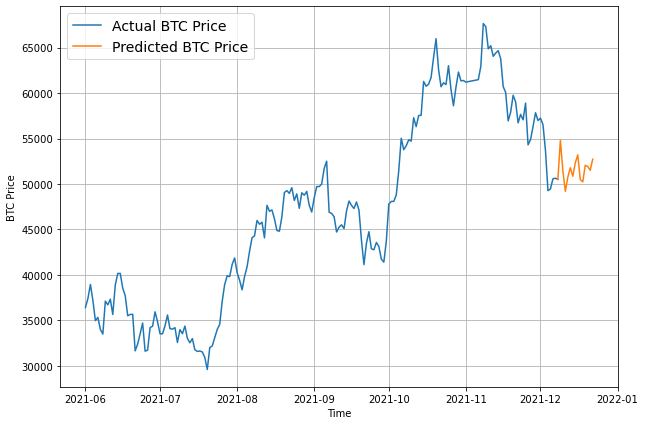

In [28]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2800, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

#### Note:
By the time you read this, the future might have already happened, if so, how did the model go?

> ⚠️ A reminder, the predictions here are not financial advice.